In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import null_space
import jlinops

# Helper functions

In [2]:
def generate_matrix_with_rank(k, n, r):
    if r > min(k, n):
        raise ValueError("Rank r cannot be greater than min(k, n)")

    # Step 1: Generate a k x r matrix with rank r
    # This is done by generating a random matrix and using QR decomposition to ensure it has rank r.
    A = np.random.rand(k, r)
    Q, R = np.linalg.qr(A)  # QR decomposition
    A = Q[:, :r]  # Ensure the matrix has rank r

    # Step 2: Extend to a k x n matrix while preserving rank r
    if n > r:
        # Generate a random r x (n-r) matrix
        B = np.random.rand(r, n-r)
        # Multiply to get the additional columns
        additional_columns = np.dot(A, B)
        # Concatenate to get the final k x n matrix
        final_matrix = np.hstack((A, additional_columns))
    else:
        final_matrix = A

    return final_matrix

# Make random test problem

In [3]:
np.random.seed(1)

# Parameters
n = 100
m = 65
k = 150
rF = 23
rR = n-3

# Gen matrices
F = generate_matrix_with_rank(m, n, rF)
R = generate_matrix_with_rank(k, n, rR)

# Check common kernel
A = np.vstack([F, R])
assert np.linalg.matrix_rank(A) == n, "common kernel condition not satisfied"

b1 = np.random.normal(size=m)
b2 = np.random.normal(size=k)
bstack = np.hstack([b1, b2])

# Get solution from original problem form
x_original_sol, _, _, _ = np.linalg.lstsq( A, bstack )

Rpinv = np.linalg.pinv(R)
W = null_space(R)
FWpinv = np.linalg.pinv(F @ W)
xker = W @ FWpinv @ b1

G = np.eye(n) - ( W @ FWpinv @ F )
H = F @ G
Mpinv = np.linalg.pinv(R.T @ R)
Ropinv = G @ Rpinv 

# Get solution via transformed method
Atilde = np.vstack([F @ Ropinv, np.eye(k)])
bt = np.hstack([b1, R @ Rpinv @ b2])
w_original_sol, _, _, _ = np.linalg.lstsq( Atilde, bt)
x_transformed_sol = xker + (Ropinv @ w_original_sol)


/var/folders/fn/xbs7g2ln57x3xrdggzf_dzzm0000gr/T/ipykernel_88740/2421180631.py:23: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  x_original_sol, _, _, _ = np.linalg.lstsq( A, bstack )
/var/folders/fn/xbs7g2ln57x3xrdggzf_dzzm0000gr/T/ipykernel_88740/2421180631.py:38: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  w_original_sol, _, _, _ = np.linalg.lstsq( Atilde, bt)


In [4]:
def epcgls(F, R, Mpinv, W, b1, b2, x0=None, maxiter=None, tol=1e-3, FWpinv=None, relative=True, early_stopping=True):
    """Implements the efficient priorconditioned CGLS algorithm.
    """

    n = F.shape[1]
    m = F.shape[0]
    k = R.shape[0]

    if FWpinv is None:
        FWpinv = jlinops.QRPinvOperator(F @ W.A)
    else:
        pass

    G = jlinops.IdentityOperator((n,n)) - W @ FWpinv @ F
    H = F @ G

    # Compute solution in the kernel
    xker = W @ (FWpinv @ b1)

    # Handle initialization
    if x0 is None:
        x = np.zeros(n)
    else:
        x = x0

    if maxiter is None:
        maxiter = n

    # Other setup
    b2tilde = Mpinv @ (R.T @  b2)
    b2bar = R @ b2tilde
    d = np.hstack([b1 - F @ x  , b2bar - R @ x])
    d1, d2 = d[:m], d[m:]
    omega = Mpinv @ ( H.T @ d1)
    r_prev = (R @ omega) + d2
    p = r_prev.copy()
    xi = (G @ b2tilde) - x
    zeta = (G @ omega) + xi
    z = np.hstack([ F @ zeta, p ])
    n_iters = 0

    # Tracking residual norm
    bstacked = np.hstack([b1, b2])
    bnorm = np.linalg.norm(bstacked)
    x_sol = xker + x
    init_residual = np.hstack([F @ x_sol, R @ x_sol]) - bstacked
    init_residual_tr = (F.T @ init_residual[:m]) + (R.T @ init_residual[m:])
    init_residual_tr_norm = np.linalg.norm(init_residual_tr)
    residual_tr_norms = [init_residual_tr_norm]


    # Check if stopping criterion already satisfied?
    stopping_criteria_satisfied = False
    if early_stopping:
        if relative:
            if (init_residual_tr_norm/bnorm) < tol:
                stopping_criteria_satisfied = True
        else:
            if init_residual_tr_norm < tol:
                stopping_criteria_satisfied = True

    if stopping_criteria_satisfied:
        data = {
            "x": x_sol,
            #"residual_norms": residual_tr_norms,
            #"x_norms": xp.asarray(x_norms),
            "n_iters": n_iters,
            "converged": stopping_criteria_satisfied,
            "At_residual_norms": residual_tr_norms,
        }
        return data
    
    else:

        for j in range(maxiter):

            # Compute update
            alpha = (np.linalg.norm(r_prev)**2)/(np.linalg.norm(z)**2)
            x += alpha*zeta
            d -= alpha*z
            d1, d2 = d[:m], d[m:]
            omega = Mpinv @ (H.T @ d1)
            r_next = (R @ omega) + d2
            beta = ((np.linalg.norm(r_next))**2)/(np.linalg.norm(r_prev)**2)
            p = r_next + beta*p
            xi -= alpha*zeta
            zeta = (G @ omega) + xi + beta*zeta
            z = np.hstack([F @ zeta, p])

            # Update remaining
            r_prev = r_next
            n_iters += 1

            # Track residual and solution norm
            x_sol = xker + x
            residual = np.hstack([F @ x_sol, R @ x_sol]) - bstacked
            residual_tr = (F.T @ residual[:m]) + (R.T @ residual[m:])
            residual_tr_norm = np.linalg.norm(residual_tr)
            residual_tr_norms.append(residual_tr_norm)


            # Stopping criteria?
            if early_stopping:
                if relative:
                    if (residual_tr_norm/bnorm) < tol:
                        stopping_criteria_satisfied = True
                        break
                else:
                    if residual_tr_norm < tol:
                        stopping_criteria_satisfied = True
                        break
        
        data = {
            "x": x_sol,
            # "residual_norms": xp.asarray(residual_norms),
            #"x_norms": xp.asarray(x_norms),
            "n_iters": n_iters,
            #"iterates": None,
            #"search_vectors": None,
            "converged": stopping_criteria_satisfied,
            "At_residual_norms": residual_tr_norms,
        }

        # if return_search_vectors:
        #     data["search_vectors"] = xp.vstack(search_vectors).T

        # if return_iterates:
        #     data["iterates"] = xp.vstack(iterates).T

        return data

In [6]:
F = jlinops.MatrixLinearOperator(F)
R = jlinops.MatrixLinearOperator(R)
Mpinv = jlinops.MatrixLinearOperator(Mpinv)
W = jlinops.MatrixLinearOperator(W)

In [7]:
soldata = epcgls(F, R, Mpinv, W, b1, b2, x0=None, maxiter=None, tol=1e-10, relative=True, early_stopping=True)

In [8]:
np.linalg.norm( x_original_sol - soldata["x"] )

1.3597443637623524e-10

In [9]:
np.linalg.norm(x_original_sol - x_transformed_sol)

3.763163892659184e-14

In [10]:
W

<100x3 MatrixLinearOperator with dtype=float64>

In [11]:
jlinops.QRPinvOperator(F @ W.A)

<3x65 QRPinvOperator with dtype=float64>

In [12]:
soldata = jlinops.epcgls(F, R, Mpinv, W, b1, shift=b2, x0=None, maxiter=None, tol=1e-10, relative=True, early_stopping=True)

In [13]:
np.linalg.norm( x_original_sol - soldata["x"] )

1.3597442599472647e-10

In [14]:
np.linalg.norm(x_original_sol - x_transformed_sol)

3.763163892659184e-14

# Now load from library?

In [110]:
np.random.seed(2)

# Parameters
n = 1000
m = 1000
k = 3000
rF = 900
rR = n-3

# n = 1000
# m = 1000
# k = 1000
# rF = 1000
# rR = n-3

# Gen matrices
F = generate_matrix_with_rank(m, n, rF)
R = generate_matrix_with_rank(k, n, rR)

# Check common kernel
A = np.vstack([F, R])
assert np.linalg.matrix_rank(A) == n, "common kernel condition not satisfied"

b1 = np.random.normal(size=m)
#b2 = np.random.normal(size=k)
b2 = np.zeros(k)
bstack = np.hstack([b1, b2])

# Get solution from original problem form
x_original_sol, _, _, _ = np.linalg.lstsq( A, bstack )

Rpinv = np.linalg.pinv(R)
W = null_space(R)
FWpinv = np.linalg.pinv(F @ W)
xker = W @ FWpinv @ b1

G = np.eye(n) - ( W @ FWpinv @ F )
H = F @ G
Mpinv = np.linalg.pinv(R.T @ R)
Ropinv = G @ Rpinv 

# Get solution via transformed method
Atilde = np.vstack([F @ Ropinv, np.eye(k)])
bt = np.hstack([b1, R @ Rpinv @ b2])
w_original_sol, _, _, _ = np.linalg.lstsq( Atilde, bt)
x_transformed_sol = xker + (Ropinv @ w_original_sol)


/var/folders/fn/xbs7g2ln57x3xrdggzf_dzzm0000gr/T/ipykernel_34264/1473450752.py:30: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  x_original_sol, _, _, _ = np.linalg.lstsq( A, bstack )
/var/folders/fn/xbs7g2ln57x3xrdggzf_dzzm0000gr/T/ipykernel_34264/1473450752.py:45: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  w_original_sol, _, _, _ = np.linalg.lstsq( Atilde, bt)


In [111]:
(Ropinv @ R) + (W @ FWpinv)

array([[ 1.00093340e+00,  4.10750063e-04,  7.58272211e-04, ...,
        -4.96205252e-03, -3.77207472e-02,  6.79795979e-03],
       [ 3.05572497e-04,  9.99890645e-01, -2.21417609e-05, ...,
         1.42804180e-02, -1.35325314e-02, -2.59415773e-02],
       [-4.79081503e-04, -1.29509510e-05,  9.99930205e-01, ...,
        -3.60793221e-02, -3.61053910e-03,  3.19758991e-03],
       ...,
       [-1.50901217e-03, -4.88307686e-05, -4.28752554e-04, ...,
         9.38331560e-01,  3.64637797e-02,  4.14947299e-02],
       [ 2.44319147e-03,  8.87072897e-04,  1.58761965e-03, ...,
         4.78014834e-02,  9.45502643e-01,  2.65774597e-02],
       [-9.25907347e-04, -8.08298388e-04, -1.21528803e-03, ...,
         3.58540878e-02,  3.99239773e-02,  9.49958632e-01]])

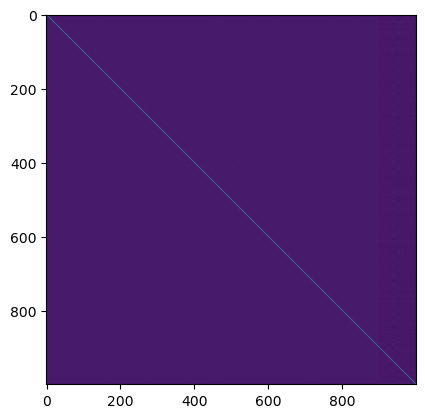

In [112]:
plt.imshow( (Ropinv @ R) + (W @ FWpinv) )
plt.show()

In [113]:
from jlinops import _CustomLinearOperator
from scipy.sparse.linalg import cg

In [114]:
F = jlinops.MatrixLinearOperator(F)
#Mpinv = jlinops.BandedCholeskyPinvOperator( jlinops.MatrixLinearOperator(R.T @ R), delta=1e-12 )
Mpinv = jlinops.MatrixLinearOperator(Mpinv)
#R = jlinops.MatrixLinearOperator(R)
W = jlinops.MatrixLinearOperator(W)
R = jlinops.MatrixLinearOperator(R)

In [115]:
# class InvCGOp(_CustomLinearOperator):
#     """Implements a Gaussian blurring operator for 1D vectors.
#     """

#     def __init__(self, M, tol=1e-3):

#         self.M = M
#         self.n = M.shape[0]
#         self.tol = tol

#         def _matvec(x):
#             res, _ = cg(self.M, x, x0=np.zeros(self.n), tol=self.tol)
#             #print(res)
#             return res
      
#         super().__init__( (n, n), _matvec, _matvec, dtype=np.float32)


# Mpinv = InvCGOp( R.T @ R, tol=1e-5)

In [116]:
soldata = jlinops.epcgls(F, R, Mpinv, W, b1, shift=b2, x0=None, maxiter=None, tol=1e-8, relative=True, early_stopping=True)

In [117]:
np.linalg.norm( x_original_sol - soldata["x"] )

2.7854129509525877e-09

In [118]:
np.linalg.norm( x_original_sol - x_transformed_sol )

1.9389210464175753e-13